In [97]:
#to view image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [137]:
#old normalizing stuff
def mean_std(loader):
    mean = 0
    std = 0
    total = 0
    for images, _ in loader:
        image_count = images.size(0)
        images = images.view(image_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += image_count
    mean /= total
    std /= total
    return mean, std

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [13]:
#calculated before for 90 non-red and 40 red training imgs

mean = [0.4741, 0.4458, 0.4370]
std = [0.2608, 0.2615, 0.2648]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
train_dataset = ImageFolder('./train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test = ImageFolder('./test', transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False)

In [8]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

resnet = models.resnet18(True)
num_ftrs = resnet.fc.in_features
number_of_classes = 2
resnet.fc = nn.Linear(num_ftrs, number_of_classes)
resnet.sigmoid = nn.Sigmoid()
# resnet = resnet.to('cpu')
criterion = nn.CrossEntropyLoss()
#momentum accelarates SGD finding
#weight_decay prevents overfitting
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [19]:
def eval_model_on_test(loader):    
    resnet.eval().cuda()
    pred_correct = 0
    total = 0
    device = 'cpu'
    with torch.no_grad():
        for inputs, labels in loader:
            # show_example(*test[0])
            # Move the inputs and labels to the device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            total += labels.size(0)
                        
            # Forward pass
            outputs = resnet(inputs)

            # Apply sigmoid function to the output tensor
            probs = torch.sigmoid(outputs)
            _, predicted = torch.max(outputs.data, 1)
            pred_correct += (predicted ==labels).sum().item()
    epoch_acc = 100 * pred_correct / total
    print("Test: Got %d out of %d correct (%.3f%%)" % (pred_correct, total, epoch_acc))
    return epoch_acc
    # print the predicted probabilities
    #sigs = nn.functional.sigmoid(outputs)
    #print(sigs)
    #print(predicted)

In [13]:
def save_checkpoint(model, epoch, opt, best_acc):
    state = {
        'epoch': epoch +1,
        'model': model.state_dict(),
        'best acc': best_acc,
        'optimizer': opt.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [14]:
# Train the model on your data
best_acc = 0
for epoch in range(10):
    print(f'Epoch number {epoch}')
    resnet.train()
    r_loss = 0.0
    r_correct = 0.0
    total = 0.0
    for images, labels in train_loader:
        images.to('cpu')
        labels.to('cpu')
        total += labels.size(0)
        
        optimizer.zero_grad()
        outputs = resnet(images)
        _, pred = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
        r_correct += (labels==pred).sum().item()
    epoch_loss = r_loss/len(train_loader)
    epoch_acc = 100.00 * r_correct / total
    print ("Training: Got %d out of %d images right (%.3f%%)" %(r_correct, total, epoch_acc))
    
    test_accuracy = eval_model_on_test(test_loader)
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        save_checkpoint(resnet, epoch, optimizer, best_acc)

Epoch number 0
Training: Got 35 out of 130 images right (26.923%)
Test: Got 23 out of 42 correct (54.762%)
Epoch number 1
Training: Got 96 out of 130 images right (73.846%)
Test: Got 19 out of 42 correct (45.238%)
Epoch number 2
Training: Got 32 out of 130 images right (24.615%)
Test: Got 23 out of 42 correct (54.762%)
Epoch number 3
Training: Got 68 out of 130 images right (52.308%)
Test: Got 19 out of 42 correct (45.238%)
Epoch number 4
Training: Got 56 out of 130 images right (43.077%)
Test: Got 25 out of 42 correct (59.524%)
Epoch number 5
Training: Got 67 out of 130 images right (51.538%)
Test: Got 28 out of 42 correct (66.667%)
Epoch number 6
Training: Got 81 out of 130 images right (62.308%)
Test: Got 23 out of 42 correct (54.762%)
Epoch number 7
Training: Got 51 out of 130 images right (39.231%)
Test: Got 19 out of 42 correct (45.238%)
Epoch number 8
Training: Got 36 out of 130 images right (27.692%)
Test: Got 19 out of 42 correct (45.238%)
Epoch number 9
Training: Got 99 out o

In [66]:
from sobol_attribution_method.torch_explainer import SobolAttributionMethod


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


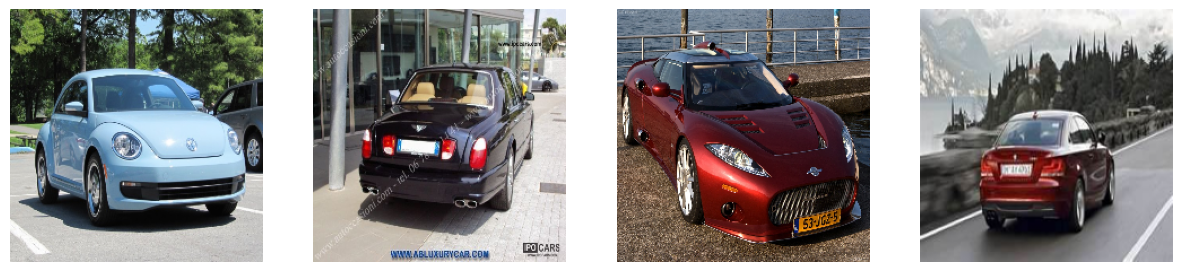

In [65]:
!pip install -q --upgrade scipy
import cv2
import numpy as np
import scipy

import torch
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
def load_image(path, size=224):
  img = cv2.resize(cv2.imread(path)[...,::-1], (size, size)) / 255.0
  img = np.moveaxis(img, -1, 0).astype(np.float32)
  return img

def show(img, **kwargs):
  if torch.is_tensor(img):
    img = img.detach().cpu().numpy()
    img = np.moveaxis(img, 0, -1)
  
  img -= img.min(); img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

images_classes = [
                  ('test/non-red/00082.jpg', 0),
                  ('test/non-red/00168.jpg', 0),
                  ('test/red/00029.jpg', 1),
                  ('test/red/00122.jpg', 1),
]

x = torch.Tensor(np.array([load_image(p) for p, y in images_classes])).cpu()
y = np.array([y for p, y in images_classes])

plt.rcParams["figure.figsize"] = [15, 6]
for i in range(len(x)):
  plt.subplot(1, len(x), i+1)
  show(x[i])
plt.show()

model = torch.load('model_best_checkpoint.pth.tar')

In [67]:
explainer = SobolAttributionMethod(model, grid_size=8, nb_design=32, batch_size=128)
explanations = explainer(x, y)

for i in range(len(x)):
  plt.subplot(1, len(x), i+1)
  show(x[i])
  show(explanations[i], cmap='jet', alpha=0.5)
plt.show()

TypeError: 'dict' object is not callable